## Semi-Supervised Learning

In [375]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report   
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
import random 
pd.options.mode.chained_assignment = None  

In [376]:
df = pd.read_csv('Surgical.csv')
df=df.sample(frac=1)
size=len(df)

In [377]:
def spliting_data(df,tr_percent,te_percent,un_percent):
    train = df.iloc[0:round(size*(tr_percent/100))]
    test = df.iloc[round(size*(tr_percent/100)):round(size*(tr_percent/100))+round(size*(te_percent/100))]
    unlabeled = df.iloc[round(size*(tr_percent/100))+round(size*(te_percent/100)):round(size*(tr_percent/100))+round(size*(te_percent/100))+round(size*(un_percent/100))]
               
    return train,test,unlabeled

In [378]:
def making_label_data(train,test,unlabeled):
    X_train=train[['bmi','Age','asa_status','baseline_cancer' , 'baseline_charlson' , 'baseline_cvd', 'baseline_dementia', 'baseline_diabetes', 'baseline_digestive','baseline_osteoart','baseline_psych','baseline_pulmonary','ahrq_ccs','ccsComplicationRate','ccsMort30Rate','complication_rsi','dow','gender','hour','month','moonphase','mort30','mortality_rsi','race']]
    X_test=test[['bmi','Age','asa_status','baseline_cancer' , 'baseline_charlson' , 'baseline_cvd', 'baseline_dementia', 'baseline_diabetes', 'baseline_digestive','baseline_osteoart','baseline_psych','baseline_pulmonary','ahrq_ccs','ccsComplicationRate','ccsMort30Rate','complication_rsi','dow','gender','hour','month','moonphase','mort30','mortality_rsi','race']]
    X_unlabeled=unlabeled[['bmi','Age','asa_status','baseline_cancer' , 'baseline_charlson' , 'baseline_cvd', 'baseline_dementia', 'baseline_diabetes', 'baseline_digestive','baseline_osteoart','baseline_psych','baseline_pulmonary','ahrq_ccs','ccsComplicationRate','ccsMort30Rate','complication_rsi','dow','gender','hour','month','moonphase','mort30','mortality_rsi','race']]
    y_train=train['complication']
    y_test=test['complication']
    
    return X_train,X_test,X_unlabeled,y_train,y_test

### Logistic Regression

In [379]:
tr_percent=1
te_percent=25
un_percent=74
train,test,unlabeled=spliting_data(df,tr_percent,te_percent,un_percent)
X_train,X_test,X_unlabeled,y_train,y_test=making_label_data(train,test,unlabeled)

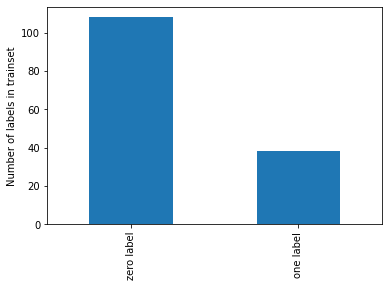

In [380]:
y_train.value_counts().plot(kind='bar')
plt.xticks([0,1], ['zero label', 'one label'])
plt.ylabel('Number of labels in trainset');

###  Pre Model Evaluation

Pre f1 Score: 0.3657142857142857
Pre accuracy: 0.757310740639519


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


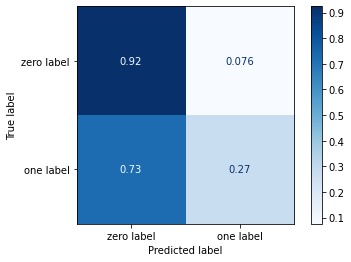

In [381]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_predict= model.predict(X_test)
pre_f1_score = f1_score(y_test,y_predict)
accuracy=model.score(X_test,y_test)
plot_confusion_matrix(model,X_test,y_test,cmap='Blues',normalize='true',display_labels=['zero label','one label']);

print("Pre f1 Score:",pre_f1_score)
print("Pre accuracy:",accuracy)

### Self Training Algorithm

In [382]:
def Updating_train_data_and_Droping_unlabeled_data(X_train,y_train,X_unlabeled,y_unlabeled,best_predicted):
    X_train_new = pd.concat([X_train,X_unlabeled.loc[best_predicted.index]], axis=0)
    y_train_new = pd.concat([y_train,best_predicted.y_unlabeled])      
    X_unlabeled_new = X_unlabeled.drop(index=best_predicted.index)
    Num_remaining_unlabel=len(X_unlabeled_new)
    
    return X_train_new,y_train_new,X_unlabeled_new,Num_remaining_unlabel

In [383]:
def Checking_thereshold_and_adding_unlabel_to_train(storing_frame,thereshold):
    
    best_pick_zero=storing_frame.loc[storing_frame["p0"] > thereshold]
    best_pick_one=storing_frame.loc[storing_frame["p1"] > thereshold]
    best_predicted = pd.concat([best_pick_zero,best_pick_one],axis=0)
    Num_adding_unlabel=len(best_predicted)

    return Num_adding_unlabel,best_predicted

In [384]:
def making_correspond_unlabels_with_correspond_probabilities(y_unlabeled,Probabilities,X_unlabeled):
    storing_frame = pd.DataFrame([])
    storing_frame["y_unlabeled"] = y_unlabeled
    storing_frame["p0"] = Probabilities[:,0]
    storing_frame["p1"] = Probabilities[:,1]
    storing_frame.index = X_unlabeled.index

    
    return storing_frame

In [385]:
def unlabeled_prediction_each_step_logistic_regression(X_train,y_train,X_test,y_test,X_unlabeled):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    Post_f1_score =f1_score(y_test,y_predict)
    Post_accuracy=model.score(X_test,y_test)
    Probabilities = model.predict_proba(X_unlabeled)
    y_unlabeled = model.predict(X_unlabeled)
    
    return Post_f1_score,Post_accuracy,Probabilities,y_unlabeled

In [386]:
def self_Training_Algorithm(X_train,y_train,X_test,y_test,X_unlabeled,thereshold):
    cnt=0
    best_predicted_values=[]
    f1_score_values=[]
    accuracy_values=[]
    best_predicted=[random.randint(1, 20)]
    while len(best_predicted) > 0:
        Post_f1_score,Post_accuracy,Probabilities,y_unlabeled=unlabeled_prediction_each_step_logistic_regression(X_train,y_train,X_test,y_test,X_unlabeled)
        storing_frame=making_correspond_unlabels_with_correspond_probabilities(y_unlabeled,Probabilities,X_unlabeled)
        Num_adding_unlabel,best_predicted=Checking_thereshold_and_adding_unlabel_to_train(storing_frame,thereshold)
        X_train_new,y_train_new,X_unlabeled_new,Num_remaining_unlabel=Updating_train_data_and_Droping_unlabeled_data(X_train,y_train,X_unlabeled,y_unlabeled,best_predicted)

        if(cnt !=0):
            f1_score_values.append(Post_f1_score)
            accuracy_values.append(Post_accuracy)
            best_predicted_values.append(Num_adding_unlabel)
            print(f"End of Iteration {cnt}")
            print(f"added {Num_adding_unlabel} new labels")
            print("f1 Score:",Post_f1_score)
            print("accuracy:",Post_accuracy)
            print(f"remaining {Num_remaining_unlabel} unlabeled")
        
        
        
        X_train=X_train_new
        y_train=y_train_new
        X_unlabeled=X_unlabeled_new
        cnt=cnt+1
               
                  
    return f1_score_values,accuracy_values,best_predicted_values

In [387]:
thereshold=0.99
f1_score_values,accuracy_values,best_predicted_values=self_Training_Algorithm(X_train,y_train,X_test,y_test,X_unlabeled,thereshold)


End of Iteration 1
added 21 new labels
f1 Score: 0.38633193863319387
accuracy: 0.7594971303634873
remaining 10759 unlabeled
End of Iteration 2
added 15 new labels
f1 Score: 0.38776928422515633
accuracy: 0.7592238316479912
remaining 10744 unlabeled
End of Iteration 3
added 10 new labels
f1 Score: 0.3933747412008281
accuracy: 0.7597704290789833
remaining 10734 unlabeled
End of Iteration 4
added 11 new labels
f1 Score: 0.3936682725395733
accuracy: 0.7592238316479912
remaining 10723 unlabeled
End of Iteration 5
added 17 new labels
f1 Score: 0.3922918100481762
accuracy: 0.7586772342169992
remaining 10706 unlabeled
End of Iteration 6
added 15 new labels
f1 Score: 0.3936899862825789
accuracy: 0.7584039355015031
remaining 10691 unlabeled
End of Iteration 7
added 12 new labels
f1 Score: 0.3934201507882111
accuracy: 0.7581306367860071
remaining 10679 unlabeled
End of Iteration 8
added 10 new labels
f1 Score: 0.3939808481532148
accuracy: 0.757857338070511
remaining 10669 unlabeled
End of Iteratio

###  Post Self-training Model Evaluation

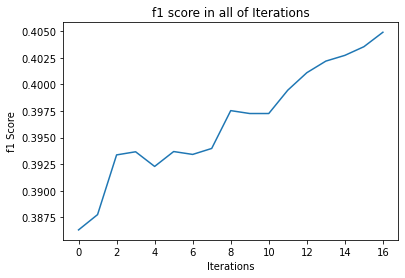

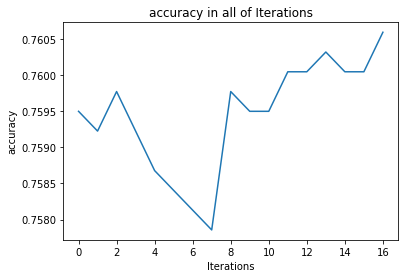

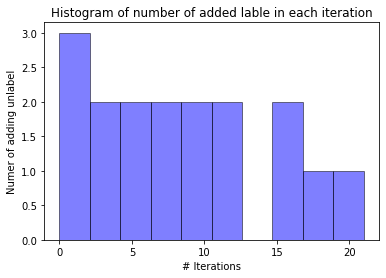

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


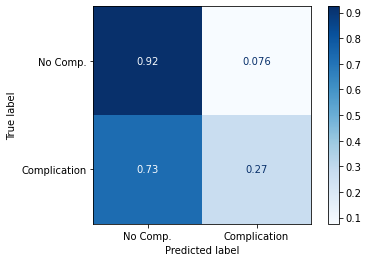

In [390]:
plt.plot(f1_score_values)
plt.xlabel('Iterations')
plt.ylabel('f1 Score')
plt.title('f1 score in all of Iterations')
plt.show()

plt.plot(accuracy_values)
plt.xlabel('Iterations')
plt.ylabel('accuracy')
plt.title('accuracy in all of Iterations')
plt.show()

plt.hist(best_predicted_values,color='blue', alpha=0.5, edgecolor='black')
plt.ylabel('Numer of adding unlabel')
plt.xlabel('# Iterations')
plt.title('Histogram of number of added lable in each iteration')
plt.show()
         

plot_confusion_matrix(model, X_test, y_test, cmap='Blues', normalize='true',display_labels=['No Comp.', 'Complication']);


### Determining The Best Threshold values

In [316]:
# from 0.7 to 0.99 threshold
f1_score_array=[]
accuracy_array=[]
T_interval=np.arange(70,100,1)/100
for threshold in T_interval:
    f1_score_values,accuracy_values,best_predicted_values=self_Training_Algorithm(X_train,y_train,X_test,y_test,X_unlabeled,thereshold)
    f1_score_array.append(f1_score_values[-1])
    accuracy_array.append(accuracy_values[-1])


End of Iteration 1
added 100 new labels
f1 Score: 0.4324970131421744
accuracy: 0.7403662202787646
remaining 10597 unlabeled
End of Iteration 2
added 96 new labels
f1 Score: 0.43683589138134593
accuracy: 0.7392730254167805
remaining 10501 unlabeled
End of Iteration 3
added 79 new labels
f1 Score: 0.4370240187463386
accuracy: 0.7373599344083083
remaining 10422 unlabeled
End of Iteration 4
added 82 new labels
f1 Score: 0.4381173736199884
accuracy: 0.7357201421153321
remaining 10340 unlabeled
End of Iteration 5
added 93 new labels
f1 Score: 0.44020797227036396
accuracy: 0.7351735446843399
remaining 10247 unlabeled
End of Iteration 6
added 87 new labels
f1 Score: 0.442020665901263
accuracy: 0.7343536485378519
remaining 10160 unlabeled
End of Iteration 7
added 92 new labels
f1 Score: 0.4430452203777905
accuracy: 0.7340803498223558
remaining 10068 unlabeled
End of Iteration 8
added 93 new labels
f1 Score: 0.4436821040594625
accuracy: 0.7340803498223558
remaining 9975 unlabeled
End of Iteratio

End of Iteration 33
added 1 new labels
f1 Score: 0.44545454545454544
accuracy: 0.7332604536758677
remaining 9401 unlabeled
End of Iteration 34
added 1 new labels
f1 Score: 0.4452015900056786
accuracy: 0.7329871549603717
remaining 9400 unlabeled
End of Iteration 35
added 0 new labels
f1 Score: 0.4457077885162024
accuracy: 0.7335337523913638
remaining 9400 unlabeled
End of Iteration 1
added 100 new labels
f1 Score: 0.4324970131421744
accuracy: 0.7403662202787646
remaining 10597 unlabeled
End of Iteration 2
added 96 new labels
f1 Score: 0.43683589138134593
accuracy: 0.7392730254167805
remaining 10501 unlabeled
End of Iteration 3
added 79 new labels
f1 Score: 0.4370240187463386
accuracy: 0.7373599344083083
remaining 10422 unlabeled
End of Iteration 4
added 82 new labels
f1 Score: 0.4381173736199884
accuracy: 0.7357201421153321
remaining 10340 unlabeled
End of Iteration 5
added 93 new labels
f1 Score: 0.44020797227036396
accuracy: 0.7351735446843399
remaining 10247 unlabeled
End of Iteratio

End of Iteration 30
added 3 new labels
f1 Score: 0.44721906923950056
accuracy: 0.7338070511068598
remaining 9407 unlabeled
End of Iteration 31
added 3 new labels
f1 Score: 0.44633730834752977
accuracy: 0.7335337523913638
remaining 9404 unlabeled
End of Iteration 32
added 2 new labels
f1 Score: 0.44545454545454544
accuracy: 0.7332604536758677
remaining 9402 unlabeled
End of Iteration 33
added 1 new labels
f1 Score: 0.44545454545454544
accuracy: 0.7332604536758677
remaining 9401 unlabeled
End of Iteration 34
added 1 new labels
f1 Score: 0.4452015900056786
accuracy: 0.7329871549603717
remaining 9400 unlabeled
End of Iteration 35
added 0 new labels
f1 Score: 0.4457077885162024
accuracy: 0.7335337523913638
remaining 9400 unlabeled
End of Iteration 1
added 100 new labels
f1 Score: 0.4324970131421744
accuracy: 0.7403662202787646
remaining 10597 unlabeled
End of Iteration 2
added 96 new labels
f1 Score: 0.43683589138134593
accuracy: 0.7392730254167805
remaining 10501 unlabeled
End of Iteration

End of Iteration 27
added 13 new labels
f1 Score: 0.44721906923950056
accuracy: 0.7338070511068598
remaining 9417 unlabeled
End of Iteration 28
added 6 new labels
f1 Score: 0.44721906923950056
accuracy: 0.7338070511068598
remaining 9411 unlabeled
End of Iteration 29
added 1 new labels
f1 Score: 0.44721906923950056
accuracy: 0.7338070511068598
remaining 9410 unlabeled
End of Iteration 30
added 3 new labels
f1 Score: 0.44721906923950056
accuracy: 0.7338070511068598
remaining 9407 unlabeled
End of Iteration 31
added 3 new labels
f1 Score: 0.44633730834752977
accuracy: 0.7335337523913638
remaining 9404 unlabeled
End of Iteration 32
added 2 new labels
f1 Score: 0.44545454545454544
accuracy: 0.7332604536758677
remaining 9402 unlabeled
End of Iteration 33
added 1 new labels
f1 Score: 0.44545454545454544
accuracy: 0.7332604536758677
remaining 9401 unlabeled
End of Iteration 34
added 1 new labels
f1 Score: 0.4452015900056786
accuracy: 0.7329871549603717
remaining 9400 unlabeled
End of Iteration

End of Iteration 25
added 9 new labels
f1 Score: 0.4478458049886621
accuracy: 0.7338070511068598
remaining 9441 unlabeled
End of Iteration 26
added 11 new labels
f1 Score: 0.4460839954597049
accuracy: 0.7332604536758677
remaining 9430 unlabeled
End of Iteration 27
added 13 new labels
f1 Score: 0.44721906923950056
accuracy: 0.7338070511068598
remaining 9417 unlabeled
End of Iteration 28
added 6 new labels
f1 Score: 0.44721906923950056
accuracy: 0.7338070511068598
remaining 9411 unlabeled
End of Iteration 29
added 1 new labels
f1 Score: 0.44721906923950056
accuracy: 0.7338070511068598
remaining 9410 unlabeled
End of Iteration 30
added 3 new labels
f1 Score: 0.44721906923950056
accuracy: 0.7338070511068598
remaining 9407 unlabeled
End of Iteration 31
added 3 new labels
f1 Score: 0.44633730834752977
accuracy: 0.7335337523913638
remaining 9404 unlabeled
End of Iteration 32
added 2 new labels
f1 Score: 0.44545454545454544
accuracy: 0.7332604536758677
remaining 9402 unlabeled
End of Iteration

End of Iteration 22
added 6 new labels
f1 Score: 0.44671201814058953
accuracy: 0.7332604536758677
remaining 9462 unlabeled
End of Iteration 23
added 6 new labels
f1 Score: 0.44721906923950056
accuracy: 0.7338070511068598
remaining 9456 unlabeled
End of Iteration 24
added 6 new labels
f1 Score: 0.4475920679886686
accuracy: 0.7335337523913638
remaining 9450 unlabeled
End of Iteration 25
added 9 new labels
f1 Score: 0.4478458049886621
accuracy: 0.7338070511068598
remaining 9441 unlabeled
End of Iteration 26
added 11 new labels
f1 Score: 0.4460839954597049
accuracy: 0.7332604536758677
remaining 9430 unlabeled
End of Iteration 27
added 13 new labels
f1 Score: 0.44721906923950056
accuracy: 0.7338070511068598
remaining 9417 unlabeled
End of Iteration 28
added 6 new labels
f1 Score: 0.44721906923950056
accuracy: 0.7338070511068598
remaining 9411 unlabeled
End of Iteration 29
added 1 new labels
f1 Score: 0.44721906923950056
accuracy: 0.7338070511068598
remaining 9410 unlabeled
End of Iteration 

End of Iteration 19
added 19 new labels
f1 Score: 0.4480998298355076
accuracy: 0.7340803498223558
remaining 9483 unlabeled
End of Iteration 20
added 10 new labels
f1 Score: 0.4459535936615733
accuracy: 0.7324405575293796
remaining 9473 unlabeled
End of Iteration 21
added 5 new labels
f1 Score: 0.44696539988655704
accuracy: 0.7335337523913638
remaining 9468 unlabeled
End of Iteration 22
added 6 new labels
f1 Score: 0.44671201814058953
accuracy: 0.7332604536758677
remaining 9462 unlabeled
End of Iteration 23
added 6 new labels
f1 Score: 0.44721906923950056
accuracy: 0.7338070511068598
remaining 9456 unlabeled
End of Iteration 24
added 6 new labels
f1 Score: 0.4475920679886686
accuracy: 0.7335337523913638
remaining 9450 unlabeled
End of Iteration 25
added 9 new labels
f1 Score: 0.4478458049886621
accuracy: 0.7338070511068598
remaining 9441 unlabeled
End of Iteration 26
added 11 new labels
f1 Score: 0.4460839954597049
accuracy: 0.7332604536758677
remaining 9430 unlabeled
End of Iteration 2

End of Iteration 16
added 19 new labels
f1 Score: 0.44696539988655704
accuracy: 0.7335337523913638
remaining 9549 unlabeled
End of Iteration 17
added 21 new labels
f1 Score: 0.4475920679886686
accuracy: 0.7335337523913638
remaining 9528 unlabeled
End of Iteration 18
added 26 new labels
f1 Score: 0.44696539988655704
accuracy: 0.7335337523913638
remaining 9502 unlabeled
End of Iteration 19
added 19 new labels
f1 Score: 0.4480998298355076
accuracy: 0.7340803498223558
remaining 9483 unlabeled
End of Iteration 20
added 10 new labels
f1 Score: 0.4459535936615733
accuracy: 0.7324405575293796
remaining 9473 unlabeled
End of Iteration 21
added 5 new labels
f1 Score: 0.44696539988655704
accuracy: 0.7335337523913638
remaining 9468 unlabeled
End of Iteration 22
added 6 new labels
f1 Score: 0.44671201814058953
accuracy: 0.7332604536758677
remaining 9462 unlabeled
End of Iteration 23
added 6 new labels
f1 Score: 0.44721906923950056
accuracy: 0.7338070511068598
remaining 9456 unlabeled
End of Iterati

accuracy: 0.7327138562448756
remaining 9643 unlabeled
End of Iteration 14
added 45 new labels
f1 Score: 0.4465799886941775
accuracy: 0.7324405575293796
remaining 9598 unlabeled
End of Iteration 15
added 30 new labels
f1 Score: 0.44671201814058953
accuracy: 0.7332604536758677
remaining 9568 unlabeled
End of Iteration 16
added 19 new labels
f1 Score: 0.44696539988655704
accuracy: 0.7335337523913638
remaining 9549 unlabeled
End of Iteration 17
added 21 new labels
f1 Score: 0.4475920679886686
accuracy: 0.7335337523913638
remaining 9528 unlabeled
End of Iteration 18
added 26 new labels
f1 Score: 0.44696539988655704
accuracy: 0.7335337523913638
remaining 9502 unlabeled
End of Iteration 19
added 19 new labels
f1 Score: 0.4480998298355076
accuracy: 0.7340803498223558
remaining 9483 unlabeled
End of Iteration 20
added 10 new labels
f1 Score: 0.4459535936615733
accuracy: 0.7324405575293796
remaining 9473 unlabeled
End of Iteration 21
added 5 new labels
f1 Score: 0.44696539988655704
accuracy: 0.7

End of Iteration 11
added 66 new labels
f1 Score: 0.4458309699376064
accuracy: 0.7329871549603717
remaining 9756 unlabeled
End of Iteration 12
added 65 new labels
f1 Score: 0.44671201814058953
accuracy: 0.7332604536758677
remaining 9691 unlabeled
End of Iteration 13
added 48 new labels
f1 Score: 0.4468325791855204
accuracy: 0.7327138562448756
remaining 9643 unlabeled
End of Iteration 14
added 45 new labels
f1 Score: 0.4465799886941775
accuracy: 0.7324405575293796
remaining 9598 unlabeled
End of Iteration 15
added 30 new labels
f1 Score: 0.44671201814058953
accuracy: 0.7332604536758677
remaining 9568 unlabeled
End of Iteration 16
added 19 new labels
f1 Score: 0.44696539988655704
accuracy: 0.7335337523913638
remaining 9549 unlabeled
End of Iteration 17
added 21 new labels
f1 Score: 0.4475920679886686
accuracy: 0.7335337523913638
remaining 9528 unlabeled
End of Iteration 18
added 26 new labels
f1 Score: 0.44696539988655704
accuracy: 0.7335337523913638
remaining 9502 unlabeled
End of Itera

End of Iteration 8
added 93 new labels
f1 Score: 0.4436821040594625
accuracy: 0.7340803498223558
remaining 9975 unlabeled
End of Iteration 9
added 78 new labels
f1 Score: 0.4449515116942384
accuracy: 0.7340803498223558
remaining 9897 unlabeled
End of Iteration 10
added 75 new labels
f1 Score: 0.4450768355150826
accuracy: 0.7335337523913638
remaining 9822 unlabeled
End of Iteration 11
added 66 new labels
f1 Score: 0.4458309699376064
accuracy: 0.7329871549603717
remaining 9756 unlabeled
End of Iteration 12
added 65 new labels
f1 Score: 0.44671201814058953
accuracy: 0.7332604536758677
remaining 9691 unlabeled
End of Iteration 13
added 48 new labels
f1 Score: 0.4468325791855204
accuracy: 0.7327138562448756
remaining 9643 unlabeled
End of Iteration 14
added 45 new labels
f1 Score: 0.4465799886941775
accuracy: 0.7324405575293796
remaining 9598 unlabeled
End of Iteration 15
added 30 new labels
f1 Score: 0.44671201814058953
accuracy: 0.7332604536758677
remaining 9568 unlabeled
End of Iteration

End of Iteration 6
added 87 new labels
f1 Score: 0.442020665901263
accuracy: 0.7343536485378519
remaining 10160 unlabeled
End of Iteration 7
added 92 new labels
f1 Score: 0.4430452203777905
accuracy: 0.7340803498223558
remaining 10068 unlabeled
End of Iteration 8
added 93 new labels
f1 Score: 0.4436821040594625
accuracy: 0.7340803498223558
remaining 9975 unlabeled
End of Iteration 9
added 78 new labels
f1 Score: 0.4449515116942384
accuracy: 0.7340803498223558
remaining 9897 unlabeled
End of Iteration 10
added 75 new labels
f1 Score: 0.4450768355150826
accuracy: 0.7335337523913638
remaining 9822 unlabeled
End of Iteration 11
added 66 new labels
f1 Score: 0.4458309699376064
accuracy: 0.7329871549603717
remaining 9756 unlabeled
End of Iteration 12
added 65 new labels
f1 Score: 0.44671201814058953
accuracy: 0.7332604536758677
remaining 9691 unlabeled
End of Iteration 13
added 48 new labels
f1 Score: 0.4468325791855204
accuracy: 0.7327138562448756
remaining 9643 unlabeled
End of Iteration 1

End of Iteration 4
added 82 new labels
f1 Score: 0.4381173736199884
accuracy: 0.7357201421153321
remaining 10340 unlabeled
End of Iteration 5
added 93 new labels
f1 Score: 0.44020797227036396
accuracy: 0.7351735446843399
remaining 10247 unlabeled
End of Iteration 6
added 87 new labels
f1 Score: 0.442020665901263
accuracy: 0.7343536485378519
remaining 10160 unlabeled
End of Iteration 7
added 92 new labels
f1 Score: 0.4430452203777905
accuracy: 0.7340803498223558
remaining 10068 unlabeled
End of Iteration 8
added 93 new labels
f1 Score: 0.4436821040594625
accuracy: 0.7340803498223558
remaining 9975 unlabeled
End of Iteration 9
added 78 new labels
f1 Score: 0.4449515116942384
accuracy: 0.7340803498223558
remaining 9897 unlabeled
End of Iteration 10
added 75 new labels
f1 Score: 0.4450768355150826
accuracy: 0.7335337523913638
remaining 9822 unlabeled
End of Iteration 11
added 66 new labels
f1 Score: 0.4458309699376064
accuracy: 0.7329871549603717
remaining 9756 unlabeled
End of Iteration 1

End of Iteration 1
added 100 new labels
f1 Score: 0.4324970131421744
accuracy: 0.7403662202787646
remaining 10597 unlabeled
End of Iteration 2
added 96 new labels
f1 Score: 0.43683589138134593
accuracy: 0.7392730254167805
remaining 10501 unlabeled
End of Iteration 3
added 79 new labels
f1 Score: 0.4370240187463386
accuracy: 0.7373599344083083
remaining 10422 unlabeled
End of Iteration 4
added 82 new labels
f1 Score: 0.4381173736199884
accuracy: 0.7357201421153321
remaining 10340 unlabeled
End of Iteration 5
added 93 new labels
f1 Score: 0.44020797227036396
accuracy: 0.7351735446843399
remaining 10247 unlabeled
End of Iteration 6
added 87 new labels
f1 Score: 0.442020665901263
accuracy: 0.7343536485378519
remaining 10160 unlabeled
End of Iteration 7
added 92 new labels
f1 Score: 0.4430452203777905
accuracy: 0.7340803498223558
remaining 10068 unlabeled
End of Iteration 8
added 93 new labels
f1 Score: 0.4436821040594625
accuracy: 0.7340803498223558
remaining 9975 unlabeled
End of Iteratio

End of Iteration 33
added 1 new labels
f1 Score: 0.44545454545454544
accuracy: 0.7332604536758677
remaining 9401 unlabeled
End of Iteration 34
added 1 new labels
f1 Score: 0.4452015900056786
accuracy: 0.7329871549603717
remaining 9400 unlabeled
End of Iteration 35
added 0 new labels
f1 Score: 0.4457077885162024
accuracy: 0.7335337523913638
remaining 9400 unlabeled
End of Iteration 1
added 100 new labels
f1 Score: 0.4324970131421744
accuracy: 0.7403662202787646
remaining 10597 unlabeled
End of Iteration 2
added 96 new labels
f1 Score: 0.43683589138134593
accuracy: 0.7392730254167805
remaining 10501 unlabeled
End of Iteration 3
added 79 new labels
f1 Score: 0.4370240187463386
accuracy: 0.7373599344083083
remaining 10422 unlabeled
End of Iteration 4
added 82 new labels
f1 Score: 0.4381173736199884
accuracy: 0.7357201421153321
remaining 10340 unlabeled
End of Iteration 5
added 93 new labels
f1 Score: 0.44020797227036396
accuracy: 0.7351735446843399
remaining 10247 unlabeled
End of Iteratio

End of Iteration 30
added 3 new labels
f1 Score: 0.44721906923950056
accuracy: 0.7338070511068598
remaining 9407 unlabeled
End of Iteration 31
added 3 new labels
f1 Score: 0.44633730834752977
accuracy: 0.7335337523913638
remaining 9404 unlabeled
End of Iteration 32
added 2 new labels
f1 Score: 0.44545454545454544
accuracy: 0.7332604536758677
remaining 9402 unlabeled
End of Iteration 33
added 1 new labels
f1 Score: 0.44545454545454544
accuracy: 0.7332604536758677
remaining 9401 unlabeled
End of Iteration 34
added 1 new labels
f1 Score: 0.4452015900056786
accuracy: 0.7329871549603717
remaining 9400 unlabeled
End of Iteration 35
added 0 new labels
f1 Score: 0.4457077885162024
accuracy: 0.7335337523913638
remaining 9400 unlabeled
End of Iteration 1
added 100 new labels
f1 Score: 0.4324970131421744
accuracy: 0.7403662202787646
remaining 10597 unlabeled
End of Iteration 2
added 96 new labels
f1 Score: 0.43683589138134593
accuracy: 0.7392730254167805
remaining 10501 unlabeled
End of Iteration

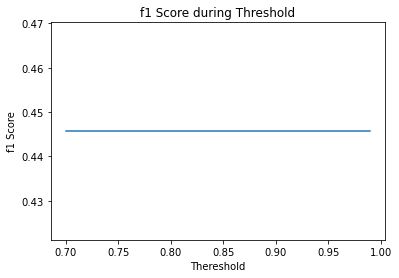

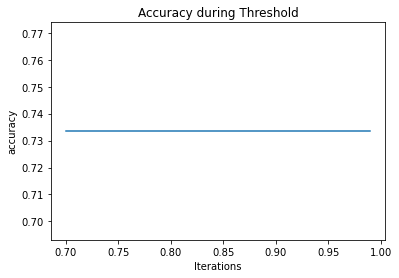

In [318]:
plt.plot(T_interval,f1_score_array)
plt.xlabel('Thereshold')
plt.ylabel('f1 Score')
plt.title('f1 Score during Threshold')
plt.show()


plt.plot(T_interval,accuracy_array)
plt.xlabel('Iterations')
plt.ylabel('accuracy')
plt.title('Accuracy during Threshold')
plt.show()